In [1]:
!pip install -U tensorflow-addons

In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm
import cv2
import seaborn as sns
import os
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Setting seeds for reproducibility.
SEED = 42
keras.utils.set_random_seed(SEED)

# Plotting settings
sns.set()
plt.rc('font', family = 'serif')

In [3]:
def get_binary_testset(dataset_name):
    """
    `DariusAf_Deepfake_Database` (train_test)
    `Celeb-avg-30-(train/test)`
    `Celeb-rnd-30-(train/test)`
    `Celeb-diff-30-(train/test)`
    """
    testset = None
    path_2_root = "../.."
    if dataset_name == "DariusAf_Deepfake_Database":
        testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database/train_test"
    elif dataset_name == "Celeb-avg-30-test":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30-test"
    elif dataset_name == "Celeb-rnd-30-test":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30-test"
    elif dataset_name == "Celeb-diff-30-test":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30-test"

    elif dataset_name == "Celeb-avg-30-train":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-avg-30"
    elif dataset_name == "Celeb-rnd-30-train":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-rnd-30"
    elif dataset_name == "Celeb-diff-30-train":
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2/Celeb-diff-30"

    elif dataset_name == "DariusAf-OC": # unary
        testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/real-train/"
    elif dataset_name == "DariusAf-OC-test": # binary
        testset = f"{path_2_root}/_DATASETS/DariusAf_Deepfake_Database-OC/realfake-test/"

    elif dataset_name == "Celeb-DF-v2-OC": # unary
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-train/"
    elif dataset_name == "Celeb-DF-v2-OC-val": # # unary
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-real-val/"
    elif dataset_name == "Celeb-DF-v2-OC-test": # # unary
        testset = f"{path_2_root}/_DATASETS/Celeb-DF-v2-OC/Celeb-rnd-30-OC-realfake-test/"
    return testset

In [4]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 64
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (100, 100, 3)
NUM_CLASSES = 10

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 1000

# AUGMENTATION
IMAGE_SIZE = 100  # We will resize input images to this size.
PATCH_SIZE = IMAGE_SIZE // 8 # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.75  # We have found 75% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

In [5]:
DATASET = get_binary_testset("Celeb-DF-v2-OC")
VAL_DATASET = get_binary_testset("Celeb-DF-v2-OC-val")
TEST_DATASET = get_binary_testset("Celeb-DF-v2-OC-test")
IMG_DATAGEN = ImageDataGenerator()

GEN = IMG_DATAGEN.flow_from_directory(DATASET,
                                      target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                      batch_size=BATCH_SIZE,
                                      seed=SEED)

VAL_GEN = IMG_DATAGEN.flow_from_directory(VAL_DATASET,
                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                          batch_size=BATCH_SIZE,
                                          seed=SEED)

TEST_GEN = IMG_DATAGEN.flow_from_directory(TEST_DATASET,
                                          target_size=(IMAGE_SIZE, IMAGE_SIZE),
                                          batch_size=BATCH_SIZE,
                                          seed=SEED,
                                          class_mode="binary")

Found 5627 images belonging to 1 classes.
Found 1600 images belonging to 1 classes.
Found 19638 images belonging to 2 classes.


In [6]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.Resizing(INPUT_SHAPE[0] + 20, INPUT_SHAPE[0] + 20),
            layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal"),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model


In [7]:
class Patches(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

        # Assuming the image has three channels each patch would be
        # of size (patch_size, patch_size, 3).
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))

    def call(self, images):
        # Create patches from the input images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        # This is a utility function which accepts a batch of images and its
        # corresponding patches and help visualize one image and its patches
        # side by side.
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    # taken from https://stackoverflow.com/a/58082878/10319735
    def reconstruct_from_patch(self, patch):
        # This utility function takes patches from a *single* image and
        # reconstructs it back into the image. This is useful for the train
        # monitor callback.
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed


Index selected: 56.


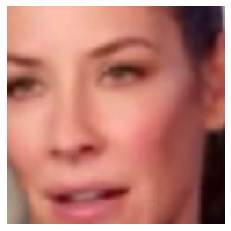

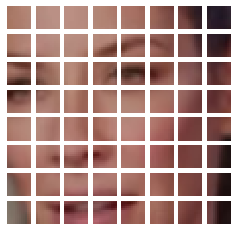

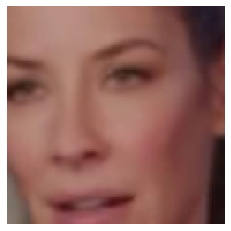

In [8]:
# Get a batch of images.
image_batch = next(iter(GEN.next()))

# Augment the images.
augmentation_model = get_train_augmentation_model()
augmented_images = augmentation_model(image_batch)

# Define the patch layer.
patch_layer = Patches()

# Get the patches from the batched images.
patches = patch_layer(images=augmented_images)

# Now pass the images and the corresponding patches
# to the `show_patched_image` method.
random_index = patch_layer.show_patched_image(images=augmented_images, patches=patches)

# Chose the same chose image and try reconstructing the patches
# into the original image.
image = patch_layer.reconstruct_from_patch(patches[random_index])
plt.imshow(image)
plt.axis("off")
plt.show()

In [9]:
class PatchEncoder(layers.Layer):
    def __init__(
        self,
        patch_size=PATCH_SIZE,
        projection_dim=ENC_PROJECTION_DIM,
        mask_proportion=MASK_PROPORTION,
        downstream=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.downstream = downstream

        # This is a trainable mask token initialized randomly from a normal
        # distribution.
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )

    def build(self, input_shape):
        (_, self.num_patches, self.patch_area) = input_shape

        # Create the projection layer for the patches.
        self.projection = layers.Dense(units=self.projection_dim)

        # Create the positional embedding layer.
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )

        # Number of patches that will be masked.
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        # Get the positional embeddings.
        batch_size = tf.shape(patches)[0]
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        pos_embeddings = self.position_embedding(positions[tf.newaxis, ...])
        pos_embeddings = tf.tile(
            pos_embeddings, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)

        # Embed the patches.
        patch_embeddings = (
            self.projection(patches) + pos_embeddings
        )  # (B, num_patches, projection_dim)

        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            # The encoder input is the unmasked patch embeddings. Here we gather
            # all the patches that should be unmasked.
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            # Get the unmasked and masked position embeddings. We will need them
            # for the decoder.
            unmasked_positions = tf.gather(
                pos_embeddings, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)
            masked_positions = tf.gather(
                pos_embeddings, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)

            # Repeat the mask token number of mask times.
            # Mask tokens replace the masks of the image.
            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            # Get the masked embeddings for the tokens.
            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )

    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx


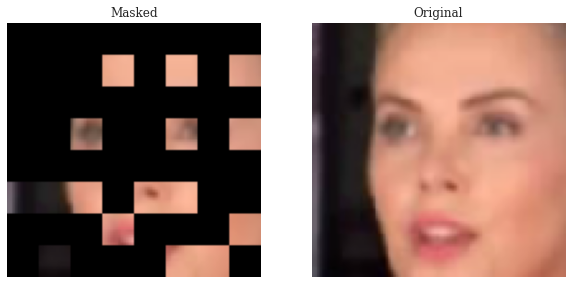

In [10]:
# Create the patch encoder layer.
patch_encoder = PatchEncoder()

# Get the embeddings and positions.
(
    unmasked_embeddings,
    masked_embeddings,
    unmasked_positions,
    mask_indices,
    unmask_indices,
) = patch_encoder(patches=patches)


# Show a maksed patch image.
new_patch, random_index = patch_encoder.generate_masked_image(patches, unmask_indices)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
img = patch_layer.reconstruct_from_patch(new_patch)
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Masked")
plt.subplot(1, 2, 2)
img = augmented_images[random_index]
plt.imshow(keras.utils.array_to_img(img))
plt.axis("off")
plt.title("Original")
plt.show()

In [11]:
def mlp(x, dropout_rate, hidden_units):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [12]:
def create_encoder(num_heads=ENC_NUM_HEADS, num_layers=ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=ENC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=ENC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")


In [13]:
def create_decoder(
    num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE
):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)

        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=DEC_PROJECTION_DIM, dropout=0.1
        )(x1, x1)

        # Skip connection 1.
        x2 = layers.Add()([attention_output, x])

        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x2)

        # MLP.
        x3 = mlp(x3, hidden_units=DEC_TRANSFORMER_UNITS, dropout_rate=0.1)

        # Skip connection 2.
        x = layers.Add()([x3, x2])

    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)

    return keras.Model(inputs, outputs, name="mae_decoder")


In [14]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        # Augment the input images.
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        # Patch the augmented images.
        patches = self.patch_layer(augmented_images)

        # Encode the patches.
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        # Pass the unmaksed patche to the encoder.
        encoder_outputs = self.encoder(unmasked_embeddings)

        # Create the decoder inputs.
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        # Decode the inputs.
        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        # Compute the total loss.
        total_loss = self.compiled_loss(loss_patch, loss_output)

        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}


In [15]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = create_encoder()
decoder = create_decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

In [16]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(VAL_GEN.next()))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_images = next(iter(VAL_GEN.next()))
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")
            plt.axis("off")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")
            plt.axis("off")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")
            plt.axis("off")
            
            plt.show()
            plt.close()


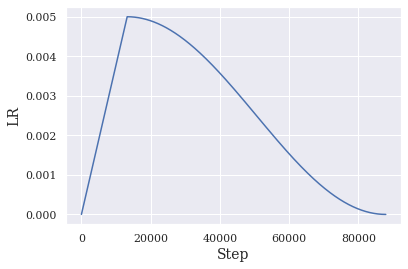

In [17]:
# Some code is taken from:
# https://www.kaggle.com/ashusma/training-rfcx-tensorflow-tpu-effnet-b2.


class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super(WarmUpCosine, self).__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )

len_x_train = GEN.n
total_steps = int((len_x_train / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

In [18]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)


# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)

def load_best_model(model):
    PATH_2_MAP_WEIGHTS_DIR = "../../_WEIGHTS/mae/"
    if os.listdir(PATH_2_MAP_WEIGHTS_DIR):
        model.load_weights(f"{PATH_2_MAP_WEIGHTS_DIR}/weights")

load_best_model(mae_model)

1/1 [==============================] - ETA: 0s - loss: 0.0188 - mae: 0.1043
Idx chosen: 16


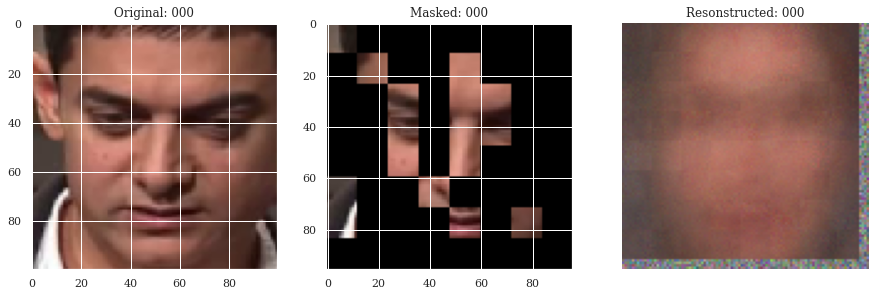

1/1 [==============================] - 8s 8s/step - loss: 0.0188 - mae: 0.1043 - val_loss: 0.0187 - val_mae: 0.1058


In [19]:
# # single bacth
X, y = GEN.next()
X = X.astype(np.uint8)
train_ds = tf.data.Dataset.from_tensor_slices(X)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

X, y = VAL_GEN.next()
val_ds = tf.data.Dataset.from_tensor_slices(X)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)
# mae_model.train_on_batch(X[0],y[0])
history = mae_model.fit(
    train_ds, epochs=1, validation_data=train_ds, callbacks=train_callbacks,
)

Epoch 1/1000
88/88 [==============================] - ETA: 0s - loss: 0.0198 - mae: 0.1072WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor. Received: inputs=(<tf.Tensor 'IteratorGetNext:0' shape=(None, None, None, None) dtype=float32>, <tf.Tensor 'IteratorGetNext:1' shape=(None, None) dtype=float32>). Consider rewriting this model with the Functional API.

Idx chosen: 29


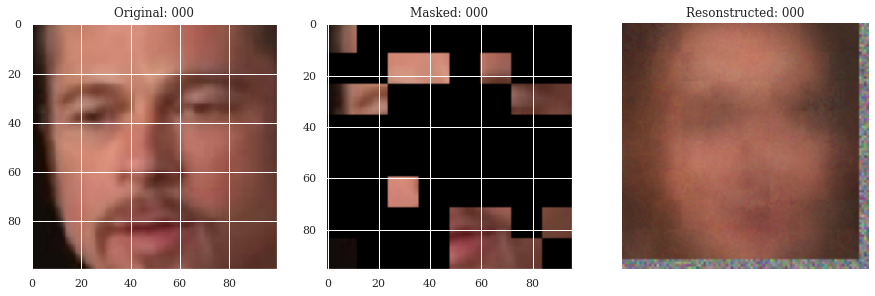

88/88 [==============================] - 23s 217ms/step - loss: 0.0198 - mae: 0.1072 - val_loss: 0.0196 - val_mae: 0.1059
Epoch 2/1000
88/88 [==============================] - 19s 212ms/step - loss: 0.0181 - mae: 0.1014 - val_loss: 0.0188 - val_mae: 0.1027
Epoch 3/1000
88/88 [==============================] - 18s 205ms/step - loss: 0.0170 - mae: 0.0980 - val_loss: 0.0175 - val_mae: 0.0993
Epoch 4/1000
88/88 [==============================] - 18s 205ms/step - loss: 0.0161 - mae: 0.0951 - val_loss: 0.0173 - val_mae: 0.0975
Epoch 5/1000
88/88 [==============================] - 18s 208ms/step - loss: 0.0157 - mae: 0.0937 - val_loss: 0.0168 - val_mae: 0.0970
Epoch 6/1000
88/88 [==============================] - ETA: 0s - loss: 0.0155 - mae: 0.0929
Idx chosen: 15


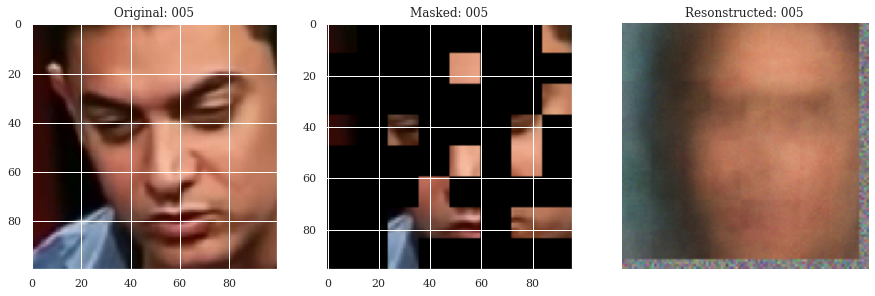

88/88 [==============================] - 19s 213ms/step - loss: 0.0155 - mae: 0.0929 - val_loss: 0.0165 - val_mae: 0.0968
Epoch 7/1000
88/88 [==============================] - 8s 95ms/step - loss: 0.0150 - mae: 0.0913 - val_loss: 0.0171 - val_mae: 0.0982
Epoch 8/1000
88/88 [==============================] - 18s 203ms/step - loss: 0.0150 - mae: 0.0912 - val_loss: 0.0161 - val_mae: 0.0945
Epoch 9/1000
88/88 [==============================] - 18s 208ms/step - loss: 0.0145 - mae: 0.0895 - val_loss: 0.0153 - val_mae: 0.0907
Epoch 10/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0142 - mae: 0.0881 - val_loss: 0.0154 - val_mae: 0.0907
Epoch 11/1000
88/88 [==============================] - ETA: 0s - loss: 0.0137 - mae: 0.0865
Idx chosen: 33


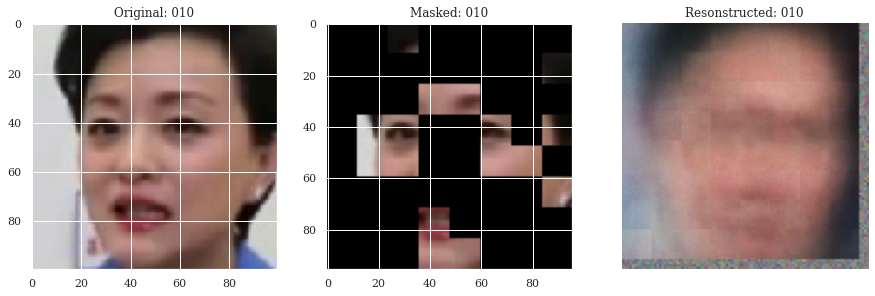

88/88 [==============================] - 8s 96ms/step - loss: 0.0137 - mae: 0.0865 - val_loss: 0.0154 - val_mae: 0.0920
Epoch 12/1000
88/88 [==============================] - 18s 204ms/step - loss: 0.0136 - mae: 0.0859 - val_loss: 0.0152 - val_mae: 0.0906
Epoch 13/1000
88/88 [==============================] - 18s 204ms/step - loss: 0.0132 - mae: 0.0845 - val_loss: 0.0150 - val_mae: 0.0890
Epoch 14/1000
88/88 [==============================] - 18s 211ms/step - loss: 0.0132 - mae: 0.0846 - val_loss: 0.0143 - val_mae: 0.0879
Epoch 15/1000
88/88 [==============================] - 19s 213ms/step - loss: 0.0130 - mae: 0.0839 - val_loss: 0.0143 - val_mae: 0.0876
Epoch 16/1000
88/88 [==============================] - ETA: 0s - loss: 0.0127 - mae: 0.0829
Idx chosen: 55


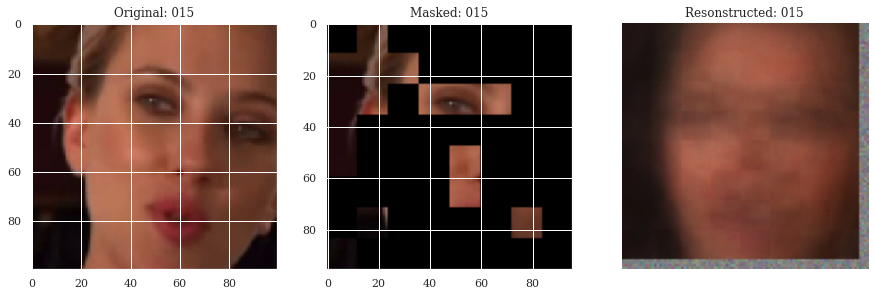

88/88 [==============================] - 9s 99ms/step - loss: 0.0127 - mae: 0.0829 - val_loss: 0.0143 - val_mae: 0.0885
Epoch 17/1000
88/88 [==============================] - 18s 201ms/step - loss: 0.0126 - mae: 0.0824 - val_loss: 0.0142 - val_mae: 0.0872
Epoch 18/1000
88/88 [==============================] - 18s 202ms/step - loss: 0.0122 - mae: 0.0811 - val_loss: 0.0141 - val_mae: 0.0865
Epoch 19/1000
88/88 [==============================] - 18s 203ms/step - loss: 0.0121 - mae: 0.0807 - val_loss: 0.0137 - val_mae: 0.0852
Epoch 20/1000
88/88 [==============================] - 9s 98ms/step - loss: 0.0120 - mae: 0.0801 - val_loss: 0.0138 - val_mae: 0.0855
Epoch 21/1000
88/88 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0810
Idx chosen: 24


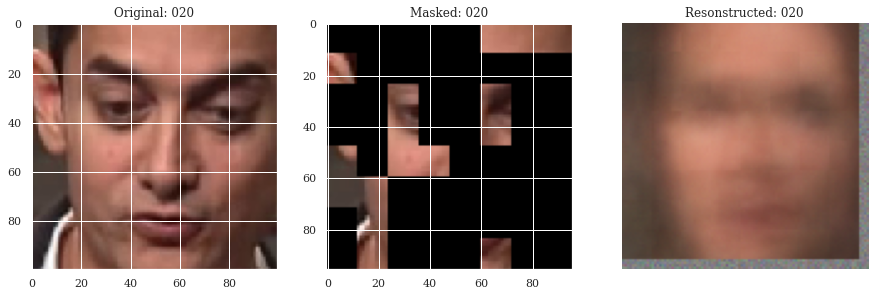

88/88 [==============================] - 8s 95ms/step - loss: 0.0121 - mae: 0.0810 - val_loss: 0.0139 - val_mae: 0.0860
Epoch 22/1000
88/88 [==============================] - 18s 202ms/step - loss: 0.0120 - mae: 0.0801 - val_loss: 0.0136 - val_mae: 0.0852
Epoch 23/1000
88/88 [==============================] - 21s 244ms/step - loss: 0.0117 - mae: 0.0793 - val_loss: 0.0135 - val_mae: 0.0840
Epoch 24/1000
88/88 [==============================] - 20s 232ms/step - loss: 0.0115 - mae: 0.0784 - val_loss: 0.0134 - val_mae: 0.0847
Epoch 25/1000
88/88 [==============================] - 10s 109ms/step - loss: 0.0115 - mae: 0.0785 - val_loss: 0.0135 - val_mae: 0.0847
Epoch 26/1000
88/88 [==============================] - ETA: 0s - loss: 0.0115 - mae: 0.0782
Idx chosen: 52


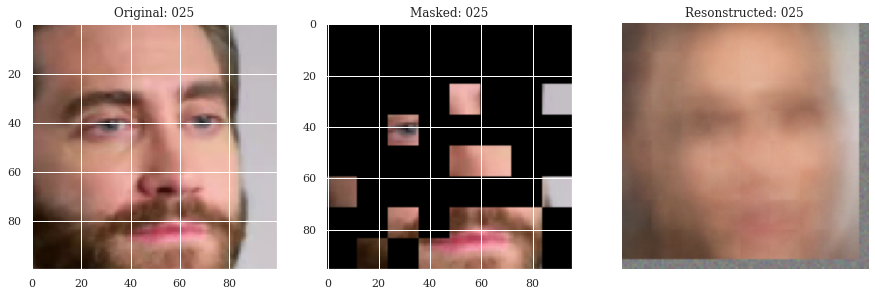

88/88 [==============================] - 22s 246ms/step - loss: 0.0115 - mae: 0.0782 - val_loss: 0.0132 - val_mae: 0.0837
Epoch 27/1000
88/88 [==============================] - 10s 109ms/step - loss: 0.0114 - mae: 0.0781 - val_loss: 0.0133 - val_mae: 0.0855
Epoch 28/1000
88/88 [==============================] - 18s 203ms/step - loss: 0.0113 - mae: 0.0774 - val_loss: 0.0129 - val_mae: 0.0828
Epoch 29/1000
88/88 [==============================] - 20s 231ms/step - loss: 0.0113 - mae: 0.0776 - val_loss: 0.0127 - val_mae: 0.0815
Epoch 30/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0112 - mae: 0.0772 - val_loss: 0.0129 - val_mae: 0.0824
Epoch 31/1000
88/88 [==============================] - ETA: 0s - loss: 0.0112 - mae: 0.0770
Idx chosen: 29


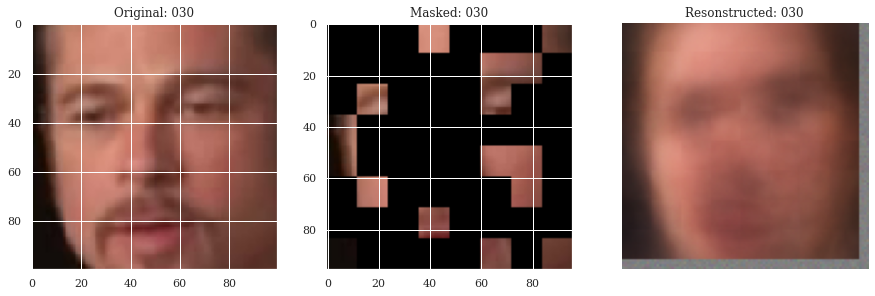

88/88 [==============================] - 8s 96ms/step - loss: 0.0112 - mae: 0.0770 - val_loss: 0.0131 - val_mae: 0.0826
Epoch 32/1000
88/88 [==============================] - 18s 208ms/step - loss: 0.0110 - mae: 0.0767 - val_loss: 0.0127 - val_mae: 0.0816
Epoch 33/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0110 - mae: 0.0762 - val_loss: 0.0127 - val_mae: 0.0814
Epoch 34/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0109 - mae: 0.0761 - val_loss: 0.0128 - val_mae: 0.0820
Epoch 35/1000
88/88 [==============================] - 8s 89ms/step - loss: 0.0107 - mae: 0.0755 - val_loss: 0.0129 - val_mae: 0.0817
Epoch 36/1000
88/88 [==============================] - ETA: 0s - loss: 0.0107 - mae: 0.0752
Idx chosen: 49


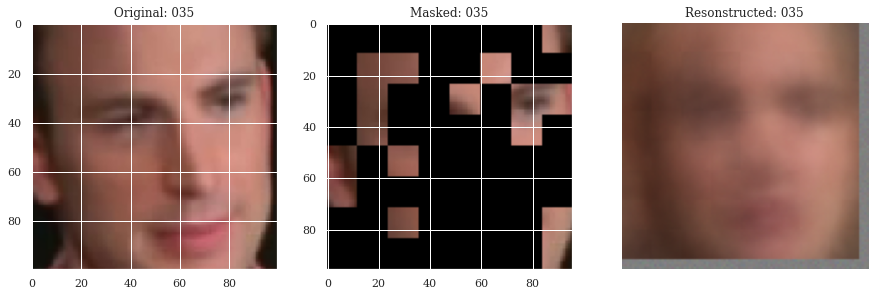

88/88 [==============================] - 8s 95ms/step - loss: 0.0107 - mae: 0.0752 - val_loss: 0.0128 - val_mae: 0.0835
Epoch 37/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0106 - mae: 0.0751 - val_loss: 0.0134 - val_mae: 0.0833
Epoch 38/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0107 - mae: 0.0755 - val_loss: 0.0128 - val_mae: 0.0829
Epoch 39/1000
88/88 [==============================] - 18s 204ms/step - loss: 0.0106 - mae: 0.0750 - val_loss: 0.0125 - val_mae: 0.0798
Epoch 40/1000
88/88 [==============================] - 18s 208ms/step - loss: 0.0105 - mae: 0.0744 - val_loss: 0.0125 - val_mae: 0.0810
Epoch 41/1000
88/88 [==============================] - ETA: 0s - loss: 0.0105 - mae: 0.0744
Idx chosen: 30


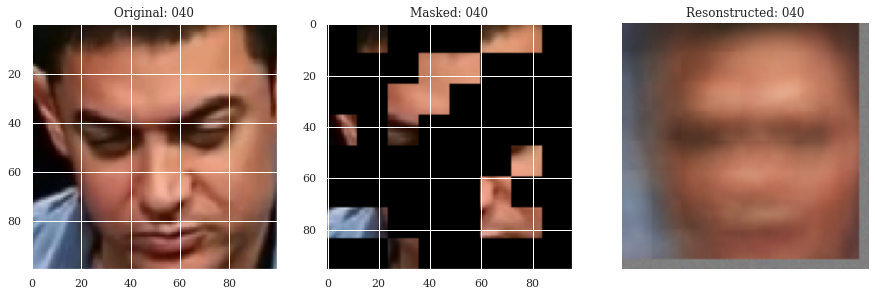

88/88 [==============================] - 18s 210ms/step - loss: 0.0105 - mae: 0.0744 - val_loss: 0.0124 - val_mae: 0.0804
Epoch 42/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0103 - mae: 0.0738 - val_loss: 0.0125 - val_mae: 0.0812
Epoch 43/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0103 - mae: 0.0740 - val_loss: 0.0124 - val_mae: 0.0803
Epoch 44/1000
88/88 [==============================] - 8s 89ms/step - loss: 0.0103 - mae: 0.0738 - val_loss: 0.0125 - val_mae: 0.0804
Epoch 45/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0104 - mae: 0.0740 - val_loss: 0.0125 - val_mae: 0.0801
Epoch 46/1000
88/88 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0732
Idx chosen: 29


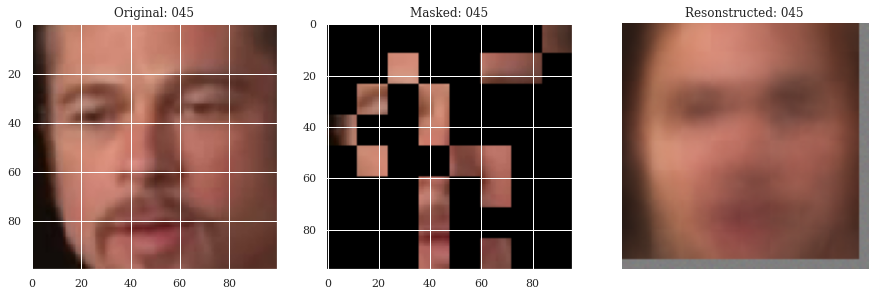

88/88 [==============================] - 8s 93ms/step - loss: 0.0102 - mae: 0.0732 - val_loss: 0.0125 - val_mae: 0.0813
Epoch 47/1000
88/88 [==============================] - 23s 260ms/step - loss: 0.0101 - mae: 0.0730 - val_loss: 0.0122 - val_mae: 0.0799
Epoch 48/1000
88/88 [==============================] - 9s 98ms/step - loss: 0.0100 - mae: 0.0725 - val_loss: 0.0125 - val_mae: 0.0810
Epoch 49/1000
88/88 [==============================] - 19s 216ms/step - loss: 0.0099 - mae: 0.0723 - val_loss: 0.0121 - val_mae: 0.0782
Epoch 50/1000
88/88 [==============================] - 9s 106ms/step - loss: 0.0101 - mae: 0.0731 - val_loss: 0.0126 - val_mae: 0.0815
Epoch 51/1000
88/88 [==============================] - ETA: 0s - loss: 0.0100 - mae: 0.0726
Idx chosen: 24


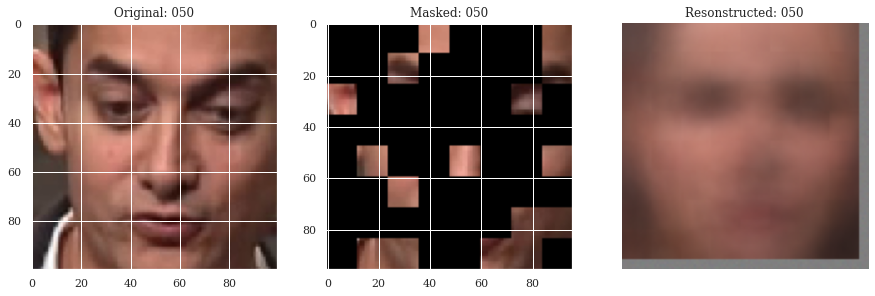

88/88 [==============================] - 8s 96ms/step - loss: 0.0100 - mae: 0.0726 - val_loss: 0.0122 - val_mae: 0.0798
Epoch 52/1000
88/88 [==============================] - 18s 210ms/step - loss: 0.0098 - mae: 0.0717 - val_loss: 0.0119 - val_mae: 0.0778
Epoch 53/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0098 - mae: 0.0719 - val_loss: 0.0123 - val_mae: 0.0812
Epoch 54/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0098 - mae: 0.0718 - val_loss: 0.0121 - val_mae: 0.0797
Epoch 55/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0097 - mae: 0.0716 - val_loss: 0.0122 - val_mae: 0.0789
Epoch 56/1000
88/88 [==============================] - ETA: 0s - loss: 0.0098 - mae: 0.0721
Idx chosen: 30


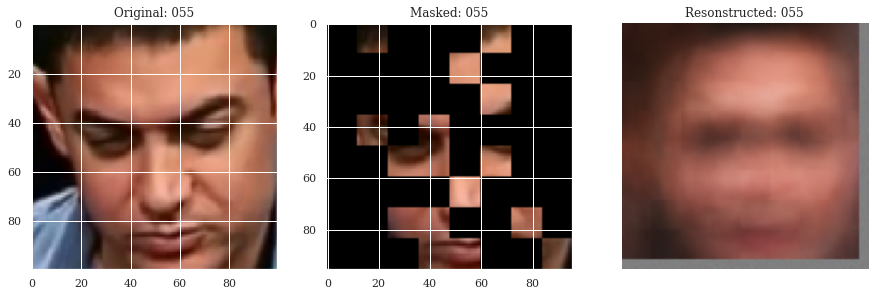

88/88 [==============================] - 8s 96ms/step - loss: 0.0098 - mae: 0.0721 - val_loss: 0.0122 - val_mae: 0.0797
Epoch 57/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0097 - mae: 0.0716 - val_loss: 0.0123 - val_mae: 0.0797
Epoch 58/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0097 - mae: 0.0717 - val_loss: 0.0122 - val_mae: 0.0792
Epoch 59/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0097 - mae: 0.0715 - val_loss: 0.0122 - val_mae: 0.0790
Epoch 60/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0096 - mae: 0.0709 - val_loss: 0.0120 - val_mae: 0.0780
Epoch 61/1000
88/88 [==============================] - ETA: 0s - loss: 0.0096 - mae: 0.0712
Idx chosen: 47


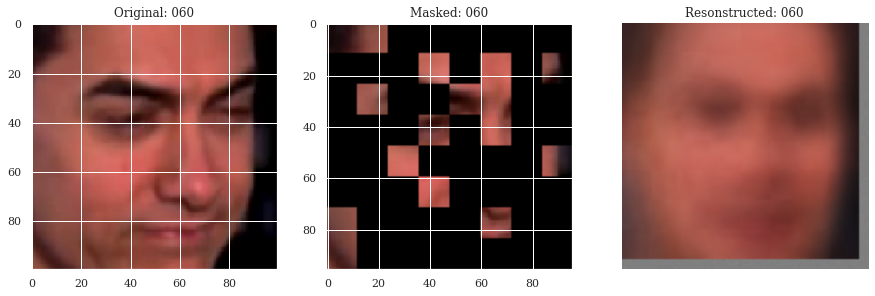

88/88 [==============================] - 8s 94ms/step - loss: 0.0096 - mae: 0.0712 - val_loss: 0.0121 - val_mae: 0.0788
Epoch 62/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0094 - mae: 0.0704 - val_loss: 0.0119 - val_mae: 0.0778
Epoch 63/1000
88/88 [==============================] - 8s 89ms/step - loss: 0.0093 - mae: 0.0701 - val_loss: 0.0122 - val_mae: 0.0789
Epoch 64/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0094 - mae: 0.0707 - val_loss: 0.0122 - val_mae: 0.0785
Epoch 65/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0096 - mae: 0.0714 - val_loss: 0.0126 - val_mae: 0.0800
Epoch 66/1000
88/88 [==============================] - ETA: 0s - loss: 0.0095 - mae: 0.0705
Idx chosen: 57


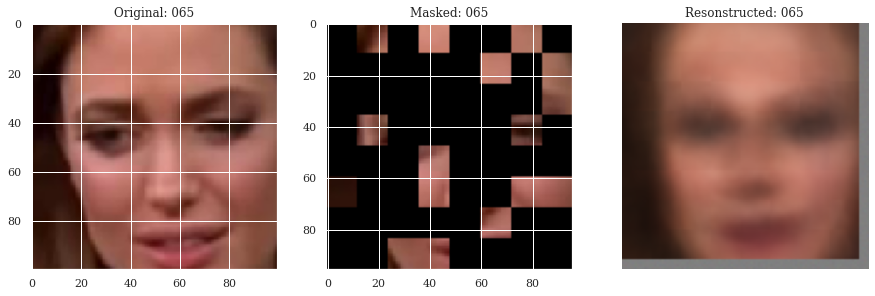

88/88 [==============================] - 8s 95ms/step - loss: 0.0095 - mae: 0.0705 - val_loss: 0.0120 - val_mae: 0.0787
Epoch 67/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0094 - mae: 0.0701 - val_loss: 0.0120 - val_mae: 0.0782
Epoch 68/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0094 - mae: 0.0702 - val_loss: 0.0124 - val_mae: 0.0800
Epoch 69/1000
88/88 [==============================] - 19s 212ms/step - loss: 0.0094 - mae: 0.0701 - val_loss: 0.0119 - val_mae: 0.0782
Epoch 70/1000
88/88 [==============================] - 8s 95ms/step - loss: 0.0094 - mae: 0.0702 - val_loss: 0.0119 - val_mae: 0.0785
Epoch 71/1000
88/88 [==============================] - ETA: 0s - loss: 0.0095 - mae: 0.0707
Idx chosen: 58


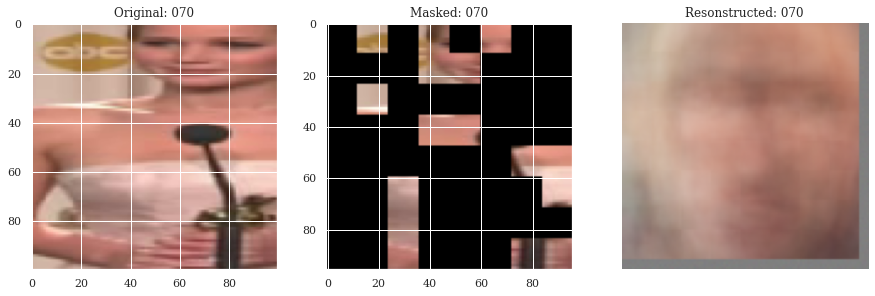

88/88 [==============================] - 8s 96ms/step - loss: 0.0095 - mae: 0.0707 - val_loss: 0.0122 - val_mae: 0.0786
Epoch 72/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0091 - mae: 0.0691 - val_loss: 0.0119 - val_mae: 0.0784
Epoch 73/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0093 - mae: 0.0700 - val_loss: 0.0120 - val_mae: 0.0780
Epoch 74/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0090 - mae: 0.0687 - val_loss: 0.0119 - val_mae: 0.0779
Epoch 75/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0090 - mae: 0.0689 - val_loss: 0.0120 - val_mae: 0.0785
Epoch 76/1000
88/88 [==============================] - ETA: 0s - loss: 0.0090 - mae: 0.0688
Idx chosen: 31


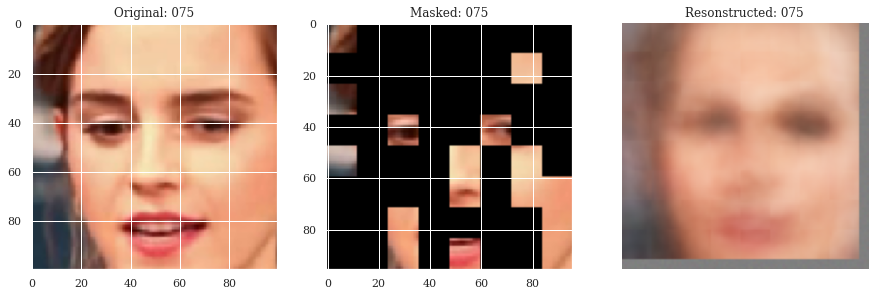

88/88 [==============================] - 18s 208ms/step - loss: 0.0090 - mae: 0.0688 - val_loss: 0.0117 - val_mae: 0.0777
Epoch 77/1000
88/88 [==============================] - 8s 96ms/step - loss: 0.0090 - mae: 0.0690 - val_loss: 0.0118 - val_mae: 0.0778
Epoch 78/1000
88/88 [==============================] - 18s 209ms/step - loss: 0.0089 - mae: 0.0685 - val_loss: 0.0117 - val_mae: 0.0774
Epoch 79/1000
88/88 [==============================] - 8s 95ms/step - loss: 0.0089 - mae: 0.0684 - val_loss: 0.0121 - val_mae: 0.0795
Epoch 80/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0090 - mae: 0.0687 - val_loss: 0.0120 - val_mae: 0.0797
Epoch 81/1000
88/88 [==============================] - ETA: 0s - loss: 0.0090 - mae: 0.0690
Idx chosen: 1


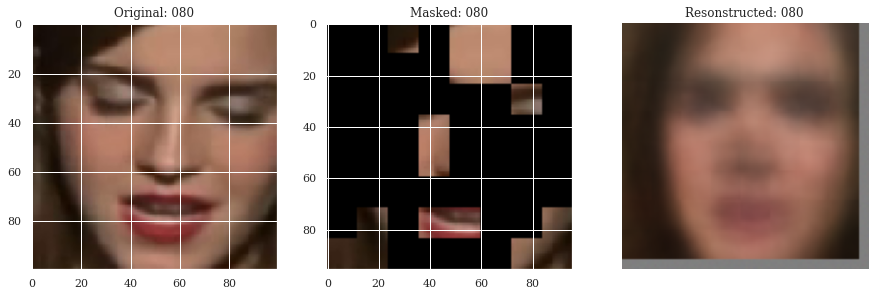

88/88 [==============================] - 8s 95ms/step - loss: 0.0090 - mae: 0.0690 - val_loss: 0.0117 - val_mae: 0.0782
Epoch 82/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0089 - mae: 0.0683 - val_loss: 0.0121 - val_mae: 0.0786
Epoch 83/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0089 - mae: 0.0685 - val_loss: 0.0120 - val_mae: 0.0782
Epoch 84/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0088 - mae: 0.0679 - val_loss: 0.0120 - val_mae: 0.0779
Epoch 85/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0089 - mae: 0.0686 - val_loss: 0.0119 - val_mae: 0.0791
Epoch 86/1000
88/88 [==============================] - ETA: 0s - loss: 0.0088 - mae: 0.0679
Idx chosen: 4


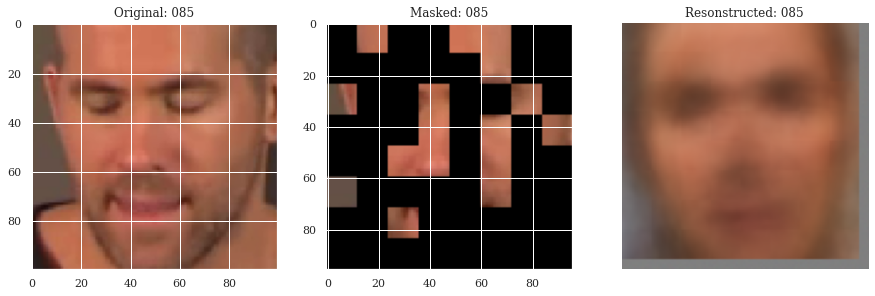

88/88 [==============================] - 8s 96ms/step - loss: 0.0088 - mae: 0.0679 - val_loss: 0.0120 - val_mae: 0.0794
Epoch 87/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0089 - mae: 0.0687 - val_loss: 0.0121 - val_mae: 0.0781
Epoch 88/1000
88/88 [==============================] - 18s 204ms/step - loss: 0.0089 - mae: 0.0686 - val_loss: 0.0117 - val_mae: 0.0773
Epoch 89/1000
88/88 [==============================] - 8s 96ms/step - loss: 0.0087 - mae: 0.0678 - val_loss: 0.0117 - val_mae: 0.0781
Epoch 90/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0086 - mae: 0.0673 - val_loss: 0.0118 - val_mae: 0.0779
Epoch 91/1000
88/88 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0675
Idx chosen: 28


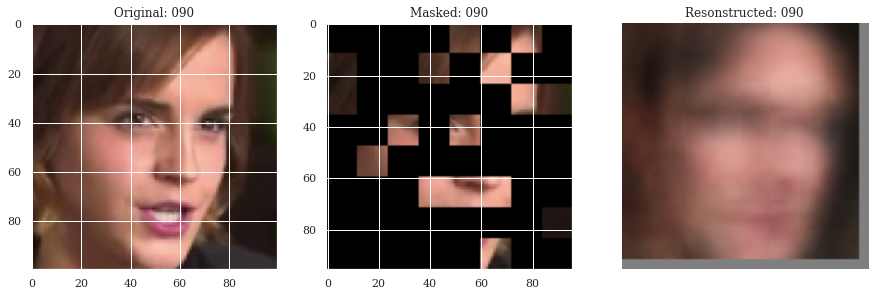

88/88 [==============================] - 8s 96ms/step - loss: 0.0087 - mae: 0.0675 - val_loss: 0.0118 - val_mae: 0.0780
Epoch 92/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0088 - mae: 0.0680 - val_loss: 0.0119 - val_mae: 0.0783
Epoch 93/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0086 - mae: 0.0672 - val_loss: 0.0117 - val_mae: 0.0772
Epoch 94/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0086 - mae: 0.0670 - val_loss: 0.0119 - val_mae: 0.0777
Epoch 95/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0089 - mae: 0.0687 - val_loss: 0.0122 - val_mae: 0.0786
Epoch 96/1000
88/88 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0675
Idx chosen: 3


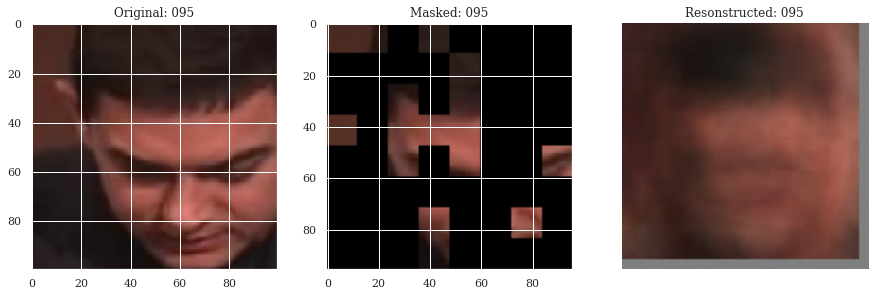

88/88 [==============================] - 8s 95ms/step - loss: 0.0087 - mae: 0.0675 - val_loss: 0.0119 - val_mae: 0.0780
Epoch 97/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0086 - mae: 0.0673 - val_loss: 0.0123 - val_mae: 0.0808
Epoch 98/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0089 - mae: 0.0682 - val_loss: 0.0119 - val_mae: 0.0785
Epoch 99/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0088 - mae: 0.0678 - val_loss: 0.0121 - val_mae: 0.0791
Epoch 100/1000
88/88 [==============================] - 18s 205ms/step - loss: 0.0085 - mae: 0.0668 - val_loss: 0.0116 - val_mae: 0.0771
Epoch 101/1000
88/88 [==============================] - ETA: 0s - loss: 0.0087 - mae: 0.0674
Idx chosen: 4


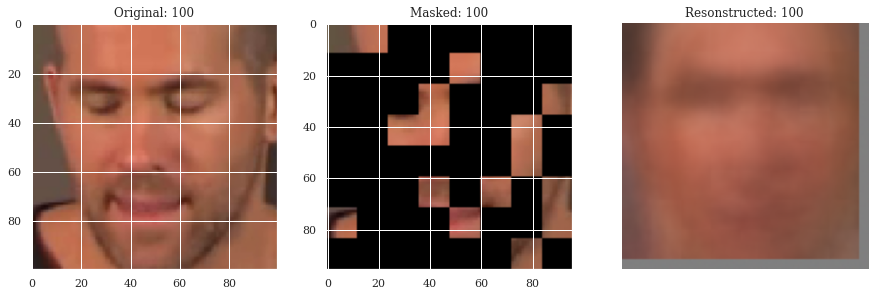

88/88 [==============================] - 9s 101ms/step - loss: 0.0087 - mae: 0.0674 - val_loss: 0.0120 - val_mae: 0.0794
Epoch 102/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0087 - mae: 0.0677 - val_loss: 0.0120 - val_mae: 0.0774
Epoch 103/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0085 - mae: 0.0669 - val_loss: 0.0119 - val_mae: 0.0770
Epoch 104/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0085 - mae: 0.0669 - val_loss: 0.0119 - val_mae: 0.0783
Epoch 105/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0083 - mae: 0.0662 - val_loss: 0.0120 - val_mae: 0.0782
Epoch 106/1000
88/88 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0667
Idx chosen: 45


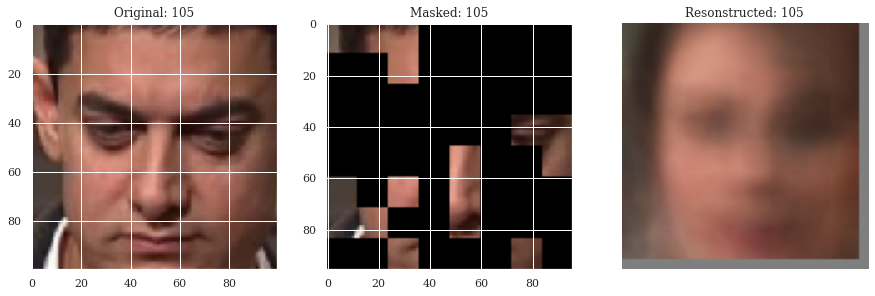

88/88 [==============================] - 8s 95ms/step - loss: 0.0085 - mae: 0.0667 - val_loss: 0.0117 - val_mae: 0.0761
Epoch 107/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0086 - mae: 0.0672 - val_loss: 0.0120 - val_mae: 0.0785
Epoch 108/1000
88/88 [==============================] - 18s 204ms/step - loss: 0.0085 - mae: 0.0669 - val_loss: 0.0115 - val_mae: 0.0763
Epoch 109/1000
88/88 [==============================] - 8s 95ms/step - loss: 0.0084 - mae: 0.0665 - val_loss: 0.0118 - val_mae: 0.0770
Epoch 110/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0083 - mae: 0.0662 - val_loss: 0.0117 - val_mae: 0.0767
Epoch 111/1000
88/88 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0667
Idx chosen: 5


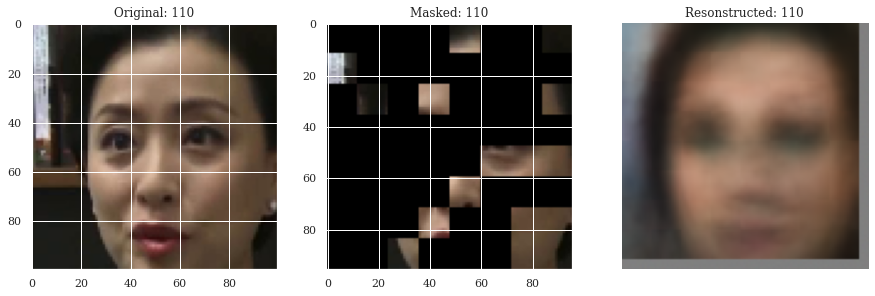

88/88 [==============================] - 8s 95ms/step - loss: 0.0085 - mae: 0.0667 - val_loss: 0.0118 - val_mae: 0.0780
Epoch 112/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0082 - mae: 0.0658 - val_loss: 0.0117 - val_mae: 0.0773
Epoch 113/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0084 - mae: 0.0664 - val_loss: 0.0117 - val_mae: 0.0771
Epoch 114/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0082 - mae: 0.0657 - val_loss: 0.0117 - val_mae: 0.0772
Epoch 115/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0085 - mae: 0.0666 - val_loss: 0.0120 - val_mae: 0.0776
Epoch 116/1000
88/88 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0655
Idx chosen: 16


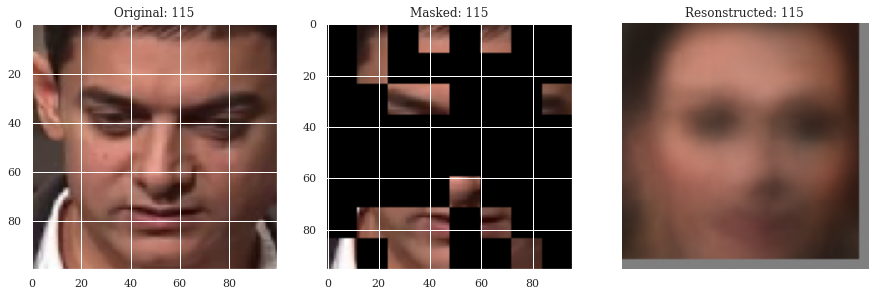

88/88 [==============================] - 8s 95ms/step - loss: 0.0082 - mae: 0.0655 - val_loss: 0.0116 - val_mae: 0.0766
Epoch 117/1000
88/88 [==============================] - 18s 205ms/step - loss: 0.0083 - mae: 0.0660 - val_loss: 0.0115 - val_mae: 0.0771
Epoch 118/1000
88/88 [==============================] - 9s 96ms/step - loss: 0.0083 - mae: 0.0660 - val_loss: 0.0119 - val_mae: 0.0774
Epoch 119/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0084 - mae: 0.0663 - val_loss: 0.0118 - val_mae: 0.0770
Epoch 120/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0082 - mae: 0.0655 - val_loss: 0.0119 - val_mae: 0.0781
Epoch 121/1000
88/88 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0658
Idx chosen: 49


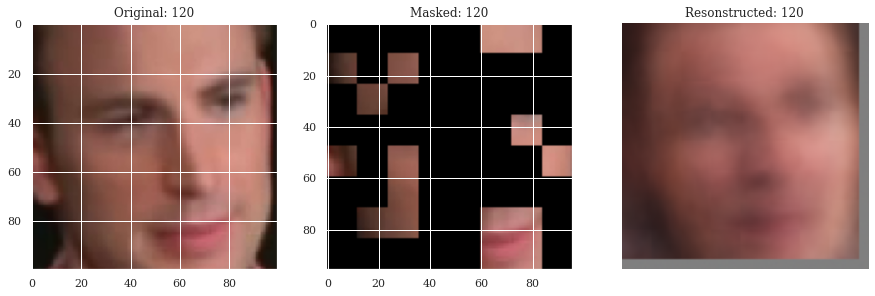

88/88 [==============================] - 8s 96ms/step - loss: 0.0082 - mae: 0.0658 - val_loss: 0.0117 - val_mae: 0.0774
Epoch 122/1000
88/88 [==============================] - 18s 206ms/step - loss: 0.0084 - mae: 0.0664 - val_loss: 0.0112 - val_mae: 0.0756
Epoch 123/1000
88/88 [==============================] - 9s 98ms/step - loss: 0.0083 - mae: 0.0660 - val_loss: 0.0116 - val_mae: 0.0766
Epoch 124/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0082 - mae: 0.0657 - val_loss: 0.0118 - val_mae: 0.0781
Epoch 125/1000
88/88 [==============================] - 8s 89ms/step - loss: 0.0083 - mae: 0.0658 - val_loss: 0.0117 - val_mae: 0.0774
Epoch 126/1000
88/88 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0657
Idx chosen: 23


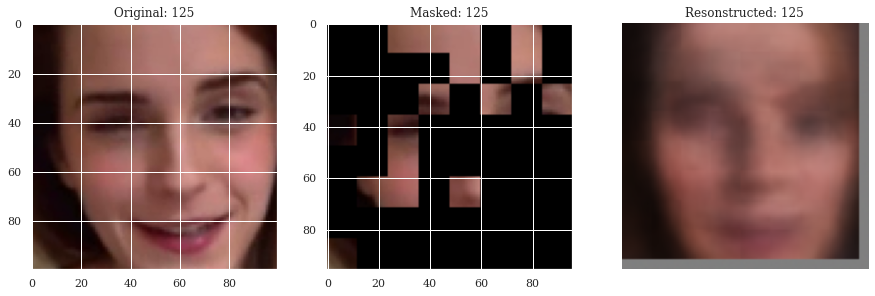

88/88 [==============================] - 8s 95ms/step - loss: 0.0082 - mae: 0.0657 - val_loss: 0.0118 - val_mae: 0.0767
Epoch 127/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0081 - mae: 0.0652 - val_loss: 0.0115 - val_mae: 0.0767
Epoch 128/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0081 - mae: 0.0651 - val_loss: 0.0116 - val_mae: 0.0770
Epoch 129/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0081 - mae: 0.0652 - val_loss: 0.0117 - val_mae: 0.0768
Epoch 130/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0084 - mae: 0.0663 - val_loss: 0.0118 - val_mae: 0.0777
Epoch 131/1000
88/88 [==============================] - ETA: 0s - loss: 0.0082 - mae: 0.0657
Idx chosen: 58


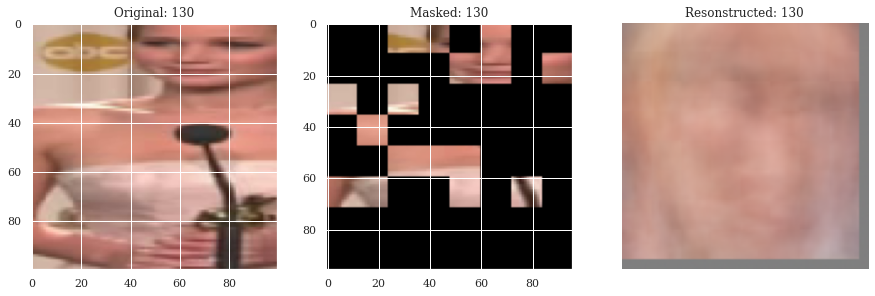

88/88 [==============================] - 8s 94ms/step - loss: 0.0082 - mae: 0.0657 - val_loss: 0.0116 - val_mae: 0.0773
Epoch 132/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0082 - mae: 0.0655 - val_loss: 0.0117 - val_mae: 0.0769
Epoch 133/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0082 - mae: 0.0655 - val_loss: 0.0119 - val_mae: 0.0784
Epoch 134/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0082 - mae: 0.0657 - val_loss: 0.0118 - val_mae: 0.0769
Epoch 135/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0082 - mae: 0.0655 - val_loss: 0.0118 - val_mae: 0.0776
Epoch 136/1000
88/88 [==============================] - ETA: 0s - loss: 0.0081 - mae: 0.0653
Idx chosen: 4


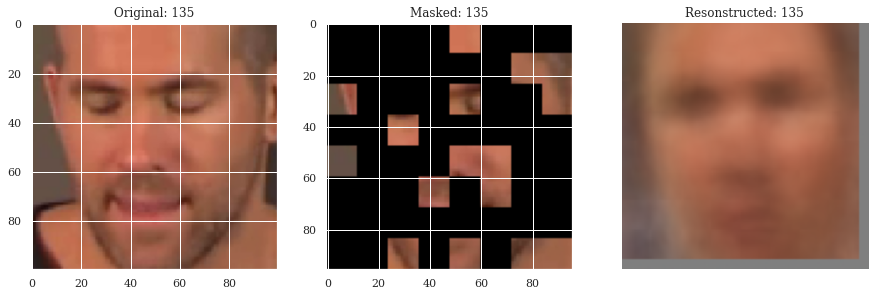

88/88 [==============================] - 8s 95ms/step - loss: 0.0081 - mae: 0.0653 - val_loss: 0.0117 - val_mae: 0.0769
Epoch 137/1000
88/88 [==============================] - 8s 92ms/step - loss: 0.0080 - mae: 0.0648 - val_loss: 0.0115 - val_mae: 0.0766
Epoch 138/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0080 - mae: 0.0647 - val_loss: 0.0114 - val_mae: 0.0761
Epoch 139/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0084 - mae: 0.0666 - val_loss: 0.0121 - val_mae: 0.0784
Epoch 140/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0081 - mae: 0.0656 - val_loss: 0.0118 - val_mae: 0.0776
Epoch 141/1000
88/88 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0648
Idx chosen: 14


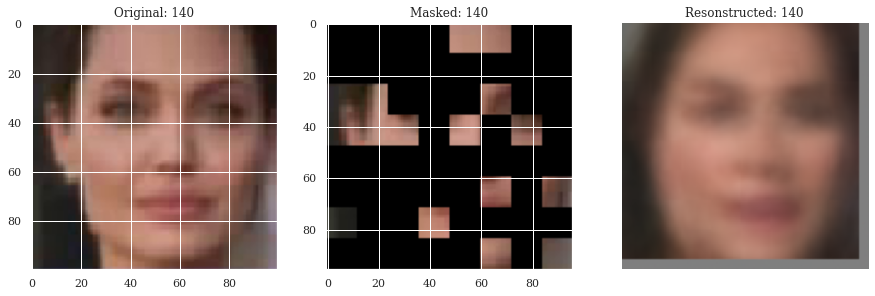

88/88 [==============================] - 8s 94ms/step - loss: 0.0080 - mae: 0.0648 - val_loss: 0.0116 - val_mae: 0.0762
Epoch 142/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0079 - mae: 0.0646 - val_loss: 0.0117 - val_mae: 0.0768
Epoch 143/1000
88/88 [==============================] - 8s 90ms/step - loss: 0.0079 - mae: 0.0645 - val_loss: 0.0116 - val_mae: 0.0768
Epoch 144/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0079 - mae: 0.0646 - val_loss: 0.0117 - val_mae: 0.0771
Epoch 145/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0080 - mae: 0.0648 - val_loss: 0.0117 - val_mae: 0.0778
Epoch 146/1000
88/88 [==============================] - ETA: 0s - loss: 0.0079 - mae: 0.0644
Idx chosen: 47


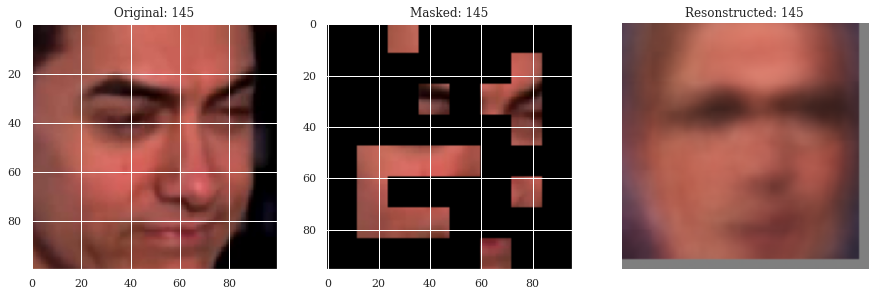

88/88 [==============================] - 8s 95ms/step - loss: 0.0079 - mae: 0.0644 - val_loss: 0.0117 - val_mae: 0.0773
Epoch 147/1000
88/88 [==============================] - 9s 96ms/step - loss: 0.0079 - mae: 0.0645 - val_loss: 0.0117 - val_mae: 0.0764
Epoch 148/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0079 - mae: 0.0646 - val_loss: 0.0119 - val_mae: 0.0776
Epoch 149/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0080 - mae: 0.0647 - val_loss: 0.0116 - val_mae: 0.0764
Epoch 150/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0079 - mae: 0.0643 - val_loss: 0.0122 - val_mae: 0.0780
Epoch 151/1000
88/88 [==============================] - ETA: 0s - loss: 0.0080 - mae: 0.0647
Idx chosen: 54


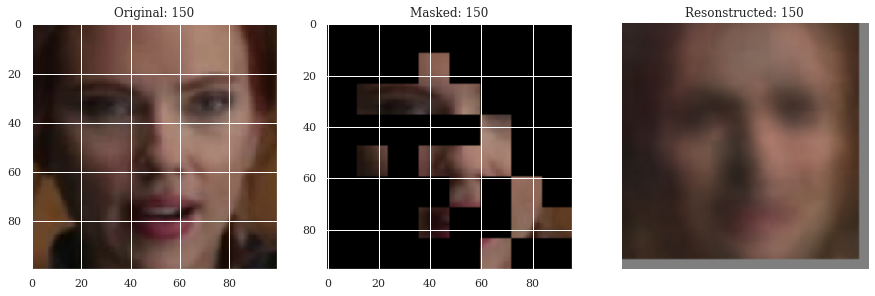

88/88 [==============================] - 9s 98ms/step - loss: 0.0080 - mae: 0.0647 - val_loss: 0.0116 - val_mae: 0.0771
Epoch 152/1000
88/88 [==============================] - 8s 96ms/step - loss: 0.0079 - mae: 0.0643 - val_loss: 0.0117 - val_mae: 0.0770
Epoch 153/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0078 - mae: 0.0642 - val_loss: 0.0119 - val_mae: 0.0771
Epoch 154/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0078 - mae: 0.0641 - val_loss: 0.0116 - val_mae: 0.0765
Epoch 155/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0079 - mae: 0.0646 - val_loss: 0.0116 - val_mae: 0.0768
Epoch 156/1000
88/88 [==============================] - ETA: 0s - loss: 0.0078 - mae: 0.0642
Idx chosen: 8


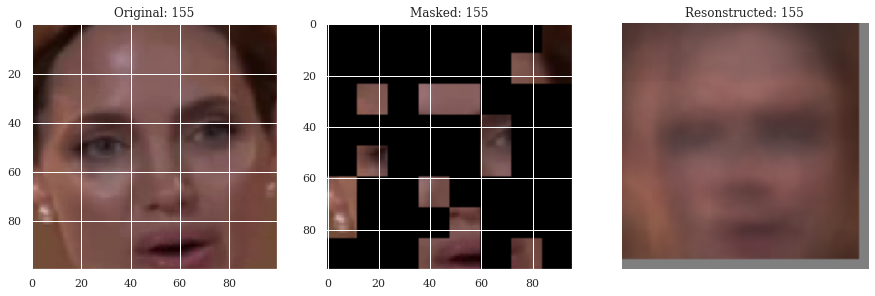

88/88 [==============================] - 9s 98ms/step - loss: 0.0078 - mae: 0.0642 - val_loss: 0.0117 - val_mae: 0.0770
Epoch 157/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0078 - mae: 0.0638 - val_loss: 0.0117 - val_mae: 0.0769
Epoch 158/1000
88/88 [==============================] - 8s 95ms/step - loss: 0.0079 - mae: 0.0643 - val_loss: 0.0116 - val_mae: 0.0767
Epoch 159/1000
88/88 [==============================] - 9s 99ms/step - loss: 0.0078 - mae: 0.0640 - val_loss: 0.0115 - val_mae: 0.0762
Epoch 160/1000
88/88 [==============================] - 8s 96ms/step - loss: 0.0077 - mae: 0.0635 - val_loss: 0.0117 - val_mae: 0.0769
Epoch 161/1000
88/88 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0631
Idx chosen: 11


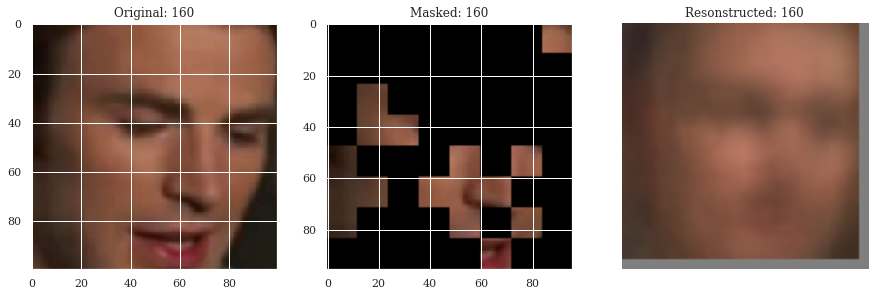

88/88 [==============================] - 9s 101ms/step - loss: 0.0076 - mae: 0.0631 - val_loss: 0.0114 - val_mae: 0.0758
Epoch 162/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0077 - mae: 0.0637 - val_loss: 0.0114 - val_mae: 0.0762
Epoch 163/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0077 - mae: 0.0635 - val_loss: 0.0117 - val_mae: 0.0769
Epoch 164/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0076 - mae: 0.0633 - val_loss: 0.0118 - val_mae: 0.0771
Epoch 165/1000
88/88 [==============================] - 9s 98ms/step - loss: 0.0075 - mae: 0.0628 - val_loss: 0.0116 - val_mae: 0.0764
Epoch 166/1000
88/88 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0632
Idx chosen: 34


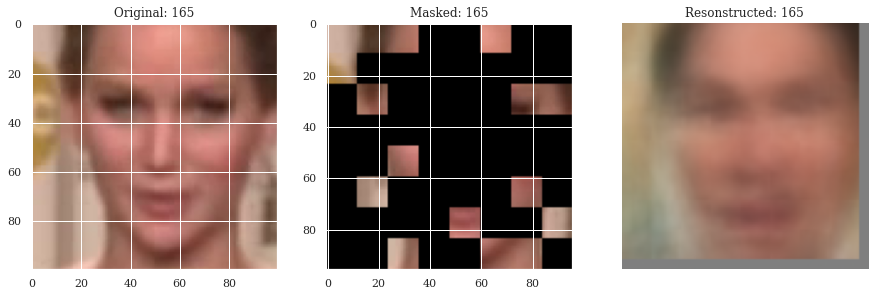

88/88 [==============================] - 9s 103ms/step - loss: 0.0076 - mae: 0.0632 - val_loss: 0.0113 - val_mae: 0.0758
Epoch 167/1000
88/88 [==============================] - 9s 96ms/step - loss: 0.0077 - mae: 0.0634 - val_loss: 0.0121 - val_mae: 0.0773
Epoch 168/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0076 - mae: 0.0633 - val_loss: 0.0116 - val_mae: 0.0767
Epoch 169/1000
88/88 [==============================] - 8s 94ms/step - loss: 0.0076 - mae: 0.0632 - val_loss: 0.0116 - val_mae: 0.0765
Epoch 170/1000
88/88 [==============================] - 9s 98ms/step - loss: 0.0077 - mae: 0.0637 - val_loss: 0.0119 - val_mae: 0.0775
Epoch 171/1000
88/88 [==============================] - ETA: 0s - loss: 0.0076 - mae: 0.0633
Idx chosen: 26


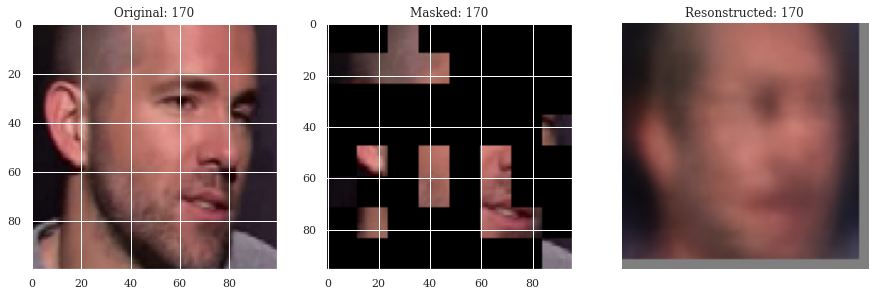

88/88 [==============================] - 9s 105ms/step - loss: 0.0076 - mae: 0.0633 - val_loss: 0.0122 - val_mae: 0.0787
Epoch 172/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0076 - mae: 0.0630 - val_loss: 0.0117 - val_mae: 0.0774
Epoch 173/1000
88/88 [==============================] - 8s 95ms/step - loss: 0.0075 - mae: 0.0628 - val_loss: 0.0116 - val_mae: 0.0763
Epoch 174/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0076 - mae: 0.0630 - val_loss: 0.0117 - val_mae: 0.0766
Epoch 175/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0074 - mae: 0.0625 - val_loss: 0.0113 - val_mae: 0.0754
Epoch 176/1000
88/88 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0622
Idx chosen: 7


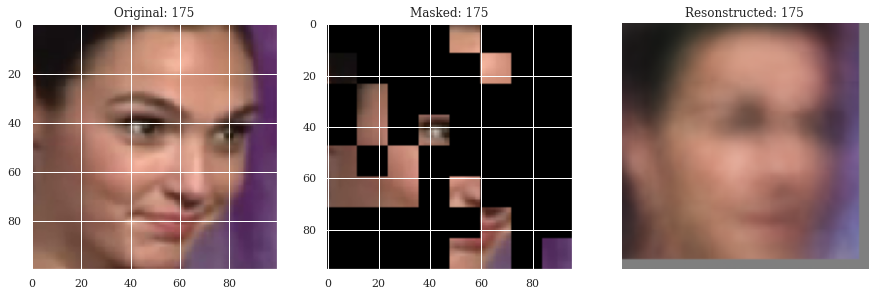

88/88 [==============================] - 9s 98ms/step - loss: 0.0074 - mae: 0.0622 - val_loss: 0.0115 - val_mae: 0.0761
Epoch 177/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0075 - mae: 0.0627 - val_loss: 0.0113 - val_mae: 0.0761
Epoch 178/1000
88/88 [==============================] - 8s 91ms/step - loss: 0.0074 - mae: 0.0622 - val_loss: 0.0117 - val_mae: 0.0777
Epoch 179/1000
88/88 [==============================] - 9s 99ms/step - loss: 0.0074 - mae: 0.0624 - val_loss: 0.0114 - val_mae: 0.0757
Epoch 180/1000
88/88 [==============================] - 9s 98ms/step - loss: 0.0075 - mae: 0.0625 - val_loss: 0.0118 - val_mae: 0.0778
Epoch 181/1000
88/88 [==============================] - ETA: 0s - loss: 0.0075 - mae: 0.0628
Idx chosen: 55


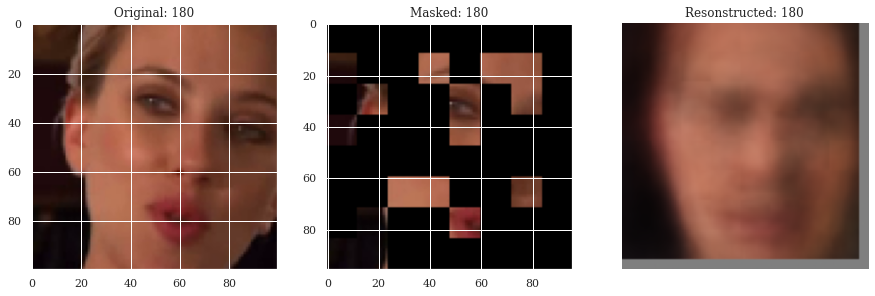

88/88 [==============================] - 9s 97ms/step - loss: 0.0075 - mae: 0.0628 - val_loss: 0.0119 - val_mae: 0.0771
Epoch 182/1000
88/88 [==============================] - 9s 96ms/step - loss: 0.0074 - mae: 0.0621 - val_loss: 0.0114 - val_mae: 0.0754
Epoch 183/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0074 - mae: 0.0623 - val_loss: 0.0117 - val_mae: 0.0765
Epoch 184/1000
88/88 [==============================] - 9s 97ms/step - loss: 0.0075 - mae: 0.0629 - val_loss: 0.0117 - val_mae: 0.0767
Epoch 185/1000
88/88 [==============================] - 8s 93ms/step - loss: 0.0075 - mae: 0.0625 - val_loss: 0.0116 - val_mae: 0.0768
Epoch 186/1000
88/88 [==============================] - ETA: 0s - loss: 0.0074 - mae: 0.0624
Idx chosen: 21


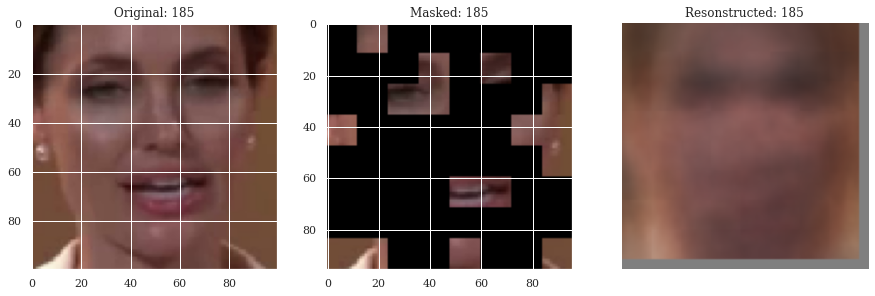

88/88 [==============================] - 9s 97ms/step - loss: 0.0074 - mae: 0.0624 - val_loss: 0.0115 - val_mae: 0.0762
Epoch 187/1000
34/88 [==========>...................] - ETA: 4s - loss: 0.0072 - mae: 0.0616

KeyboardInterrupt: 

In [20]:
patch_encoder.downstream = False
history = mae_model.fit(GEN,
                        validation_data=VAL_GEN, 
                        callbacks=\
                            train_callbacks+\
                            [ModelCheckpoint("../../_WEIGHTS/mae/weights", save_best_only=True, monitor='val_loss', mode='min', save_weights_only=True)]+\
                            [EarlyStopping(patience=50, monitor='val_loss', mode='min', restore_best_weights=True, verbose=1)],
                        epochs=EPOCHS,
                        verbose=1)

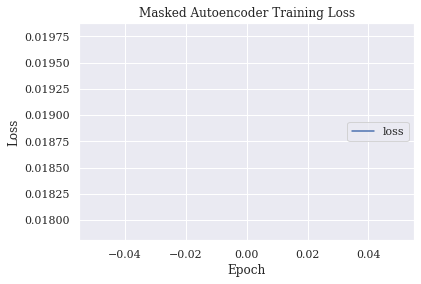

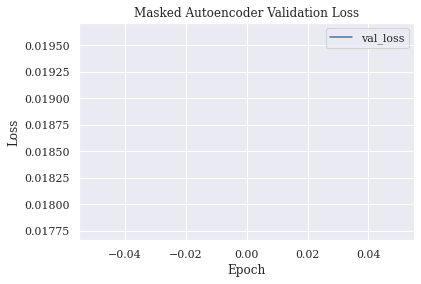

In [21]:
# Test the model after training
# test_results = model.evaluate(t_X_test, t_y_test, steps=1, verbose=False)
# print(f'Test results - Loss: {test_results[0]:3f} - mse: {100*test_results[1]:.3f}')

plt.plot(history.history['loss'])
# plt.plot(history.history['mae'])
    # plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])
plt.title('Masked Autoencoder Training Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['loss', 'mae'], loc='center right')
plt.show()

# plt.plot(history.history['loss'])
# plt.plot(history.history['mae'])
plt.plot(history.history['val_loss'])
# plt.plot(history.history['val_mae'])
plt.title('Masked Autoencoder Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['val_loss', 'val_mae'], loc='upper right')
plt.show()

In [ ]:
load_best_model(mae_model)

In [ ]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder


# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        # layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        # layers.GlobalAveragePooling1D(),
        # layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="linear_probe_model",
)
# # Pack as a model.
# downstream_model = keras.Sequential(
#     [
#         layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
#         patch_layer,
#         patch_encoder,
#         encoder,
#         layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
#         layers.GlobalAveragePooling1D(),
#         layers.Dense(NUM_CLASSES, activation="softmax"),
#     ],
#     name="linear_probe_model",
# )

# Only the final classification layer of the `downstream_model` should be trainable.
# for layer in downstream_model.layers[:-1]:
#     layer.trainable = False

downstream_model.compile()
# downstream_model.summary()

In [ ]:
score = {0:[],1:[]}
for b, (X, y) in tqdm(enumerate(TEST_GEN), total=len(TEST_GEN)-1):
    Z = downstream_model.predict(X)
    X_prime = decoder.predict(Z)
    for i in range(y.shape[0]):
        label = int(y[i])
        xi = X[i,:].flatten()
        xo = X_prime[i,:].flatten()
        recon_loss = (((xi - xo)**2).sum()/TEST_GEN.n)**0.5
        score[label].append(recon_loss)

    if b >= (TEST_GEN.samples / TEST_GEN.batch_size) - 1:
        break

    if not b % 64:
        min_r, max_r = int(min(min(score[0]), min(score[1]))), int(max(max(score[0]), max(score[1])))
        k = 4
        bins = [x*k for x in range(min_r//k -k//4, max_r//k +k//4)]
        plt.hist(score[0], bins, alpha=0.7)[2]
        plt.hist(score[1], bins, alpha=0.7)[2]
        plt.show()

In [ ]:
# def solve(m1,m2,std1,std2):
#   a = 1/(2*std1**2) - 1/(2*std2**2)
#   b = m2/(std2**2) - m1/(std1**2)
#   c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
#   return np.roots([a,b,c])

# intersec = solve(np.mean(score[1]), np.mean(score[0]), np.var(score[1]), np.mean(score[0]))

In [ ]:
min_r, max_r = int(min(min(score[0]), min(score[1]))), int(max(max(score[0]), max(score[1])))
k = 4
bins = [x*k for x in range(min_r//k -k//4, max_r//k +k//4)]
plt.hist(score[0], bins, alpha=0.7)[2]
plt.hist(score[1], bins, alpha=0.7)[2]